<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_7/DeteksiSarkasme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tugas 7
1. Buat model Deep learning (PyTorch and Tensorflow).
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC). Visualisasikan matriks akurasi dan loss.
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 70%.
5. Disarankan untuk mengerjakan tugas menggunakan Google Colab. Coba gunakan Google Colab dengan T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

### Import Dataset dan Setup Awal

In [1]:
# Cek dan aktifkan GPU jika tersedia
import tensorflow as tf

# Cek TensorFlow
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available:  []


In [2]:

# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import nltk
from nltk.corpus import stopwords
import re
import string
import time
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Download resource untuk NLP
!pip install nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Preprocessing Dataset

In [3]:
# Load dataset
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
import requests

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Path dataset
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/1a62c814ab2a0a1c080e04391824de60a70e76e0/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)
data_path = '/content/DeteksiSarkasme.json'

if response.status_code == 200:
    with open(data_path, 'wb') as f:
        f.write(response.content)
    print(f"Dataset berhasil diunduh ke: {data_path}")
else:
    print(f"Terjadi kesalahan saat mengunduh file. Status code: {response.status_code}")

print("📥 Memuat dataset dari:", data_path)
data = pd.read_json(data_path, lines=True)

print("Jumlah data sebelum preprocessing:", len(data))
print("Kolom yang tersedia:", data.columns.tolist())

# Preprocessing
def bersihkan_teks(teks):
    if pd.isnull(teks):
        return ""
    teks = teks.lower()
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    tokens = teks.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

print("\n🔧 Melakukan preprocessing pada teks ulasan...")
data['Cleaned Review'] = data['headline'].apply(bersihkan_teks)

# Preview
print("\n🧾 Contoh hasil sebelum dan sesudah dibersihkan:")
for idx in range(3):
    original = data['headline'].iloc[idx][:100]
    cleaned = data['Cleaned Review'].iloc[idx][:100]
    print(f"\nsebelum  : {original}...")
    print(f"Sesudah   : {cleaned}...")

# Statistik panjang kalimat
data['length'] = data['Cleaned Review'].apply(lambda x: len(x.split()))
print("\n📏 Statistik panjang kalimat (jumlah kata):")
print(data['length'].describe())


Dataset berhasil diunduh ke: /content/DeteksiSarkasme.json
📥 Memuat dataset dari: /content/DeteksiSarkasme.json
Jumlah data sebelum preprocessing: 26709
Kolom yang tersedia: ['article_link', 'headline', 'is_sarcastic']

🔧 Melakukan preprocessing pada teks ulasan...

🧾 Contoh hasil sebelum dan sesudah dibersihkan:

sebelum  : former versace store clerk sues over secret 'black code' for minority shoppers...
Sesudah   : former versace store clerk sues secret black code minority shoppers...

sebelum  : the 'roseanne' revival catches up to our thorny political mood, for better and worse...
Sesudah   : roseanne revival catches thorny political mood better worse...

sebelum  : mom starting to fear son's web series closest thing she will have to grandchild...
Sesudah   : mom starting fear sons web series closest thing grandchild...

📏 Statistik panjang kalimat (jumlah kata):
count    26709.000000
mean         6.984724
std          2.269902
min          0.000000
25%          5.000000
50%       

In [4]:
from sklearn.model_selection import train_test_split

# Pilih fitur dan label
fitur = data['Cleaned Review']
label = data['is_sarcastic']

# Bagi data menjadi training dan testing set
X_latih, X_uji, y_latih, y_uji = train_test_split(
    fitur, label, test_size=0.2, random_state=42, stratify=label
)

# Reset index (supaya aman untuk indexing & tokenisasi selanjutnya)
X_latih = X_latih.reset_index(drop=True)
X_uji = X_uji.reset_index(drop=True)
y_latih = y_latih.reset_index(drop=True)
y_uji = y_uji.reset_index(drop=True)

# Tampilkan informasi distribusi
print(f"\n📊 Jumlah data latih: {len(X_latih)}")
print(f"📊 Jumlah data uji: {len(X_uji)}")
print(f"🔍 Distribusi label (Training): {y_latih.value_counts().to_dict()}")
print(f"🔍 Distribusi label (Testing): {y_uji.value_counts().to_dict()}")

# Contoh sanity check
print("\n🧾 Contoh data latih:")
print("Teks:", X_latih.iloc[0])
print("Label:", y_latih.iloc[0])



📊 Jumlah data latih: 21367
📊 Jumlah data uji: 5342
🔍 Distribusi label (Training): {0: 11988, 1: 9379}
🔍 Distribusi label (Testing): {0: 2997, 1: 2345}

🧾 Contoh data latih:
Teks: fbi raids fridge
Label: 1


In [5]:
from collections import Counter

def buat_kamus_kata(daftar_teks, batas_vocab=10000):
    # Gabungkan semua kalimat dan pecah menjadi kata
    semua_kata = ' '.join(daftar_teks).split()

    # Hitung frekuensi setiap kata
    frekuensi_kata = Counter(semua_kata)

    # Ambil kata yang paling sering muncul (dikurangi token khusus)
    kata_teratas = frekuensi_kata.most_common(batas_vocab - 2)

    # Inisialisasi kamus dengan token spesial
    kamus = {'<PAD>': 0, '<UNK>': 1}
    for kata, _ in kata_teratas:
        kamus[kata] = len(kamus)

    return kamus

print("🔠 Sedang membuat kamus kata dari data latih...")
kamus_kata = buat_kamus_kata(X_latih, batas_vocab=10000)
ukuran_kamus = len(kamus_kata)
print(f"📚 Total kata dalam kamus: {ukuran_kamus}")

# Tampilkan sebagian isi kamus
print("\n📌 Contoh 20 entri pertama dalam kamus:")
for i, (kata, indeks) in enumerate(kamus_kata.items()):
    if i >= 10:
        break
    print(f"{kata}: {indeks}")


🔠 Sedang membuat kamus kata dari data latih...
📚 Total kata dalam kamus: 10000

📌 Contoh 20 entri pertama dalam kamus:
<PAD>: 0
<UNK>: 1
new: 2
man: 3
trump: 4
us: 5
one: 6
report: 7
area: 8
day: 9


In [6]:
import numpy as np

# Fungsi konversi teks ke sequence angka
def ubah_teks_ke_sequence(teks, kamus, panjang_maks=100):
    # Pecah teks menjadi daftar kata
    tokens = teks.split()

    # Ubah tiap kata menjadi indeks dari kamus, jika tidak ditemukan pakai <UNK>
    hasil_sequence = [kamus.get(kata, kamus['<UNK>']) for kata in tokens[:panjang_maks]]

    # Tambahkan padding jika panjang belum cukup
    if len(hasil_sequence) < panjang_maks:
        hasil_sequence += [kamus['<PAD>']] * (panjang_maks - len(hasil_sequence))

    return hasil_sequence

# Tentukan panjang sequence maksimal
panjang_sequence = 100

# Proses seluruh data teks menjadi sequence angka
print(f"🔁 Mengubah teks menjadi urutan angka dengan panjang {panjang_sequence}...")
X_latih_seq = np.array([ubah_teks_ke_sequence(teks, kamus_kata, panjang_sequence) for teks in X_latih])
X_uji_seq = np.array([ubah_teks_ke_sequence(teks, kamus_kata, panjang_sequence) for teks in X_uji])

# Info bentuk hasil
print(f"✅ X_latih_seq shape: {X_latih_seq.shape}")
print(f"✅ X_uji_seq shape: {X_uji_seq.shape}")

# Simpan hasil preprocessing ke file
print("\n💾 Menyimpan data hasil preprocessing...")
np.save('X_latih_seq.npy', X_latih_seq)
np.save('X_uji_seq.npy', X_uji_seq)
np.save('y_latih.npy', y_latih.values)
np.save('y_uji.npy', y_uji.values)

# Contoh hasil konversi
print("\n🧾 Contoh hasil sequence dari salah satu review:")
print(f"Teks asli: {X_latih.iloc[0][:50]}...")
print(f"Sequence: {X_latih_seq[0][:20]}...")


🔁 Mengubah teks menjadi urutan angka dengan panjang 100...
✅ X_latih_seq shape: (21367, 100)
✅ X_uji_seq shape: (5342, 100)

💾 Menyimpan data hasil preprocessing...

🧾 Contoh hasil sequence dari salah satu review:
Teks asli: fbi raids fridge...
Sequence: [ 473 4188 4189    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]...


### Tensorflow/Keras


### Proses Training RNN Models

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Tentukan panjang input sequence
input_length = 100  # Panjang sequence input yang sudah kita tentukan sebelumnya
vocab_size = len(kamus_kata)  # Ukuran kamus
embedding_dim = 128  # Ukuran vektor embedding
hidden_units = 64  # Jumlah unit LSTM dalam RNN

# Bangun model BiRNN
model = models.Sequential([
    # Layer embedding untuk mengubah kata menjadi vektor
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),

    # Bidirectional LSTM untuk membuat BiRNN
    layers.Bidirectional(layers.LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2)),

    # Fully connected layer untuk klasifikasi
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Karena kita hanya punya dua kelas (sarcastic dan tidak sarcastic)
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Ringkasan model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 146s 368ms/step - accuracy: 0.6668 - loss: 0.5837 - val_accuracy: 0.8018 - val_loss: 0.4146
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 133s 345ms/step - accuracy: 0.8677 - loss: 0.3089 - val_accuracy: 0.8145 - val_loss: 0.4243
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 152s 377ms/step - accuracy: 0.9184 - loss: 0.2073 - val_accuracy: 0.7967 - val_loss: 0.5312
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 133s 352ms/step - accuracy: 0.9447 - loss: 0.1451 - val_accuracy: 0.7890 - val_loss: 0.6654
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 120s 360ms/step - accuracy: 0.9659 - loss: 0.1006 - val_accuracy: 0.7799 - val_loss: 0.8540
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7807 - loss: 0.8582
Accuracy on test data: 77.99%


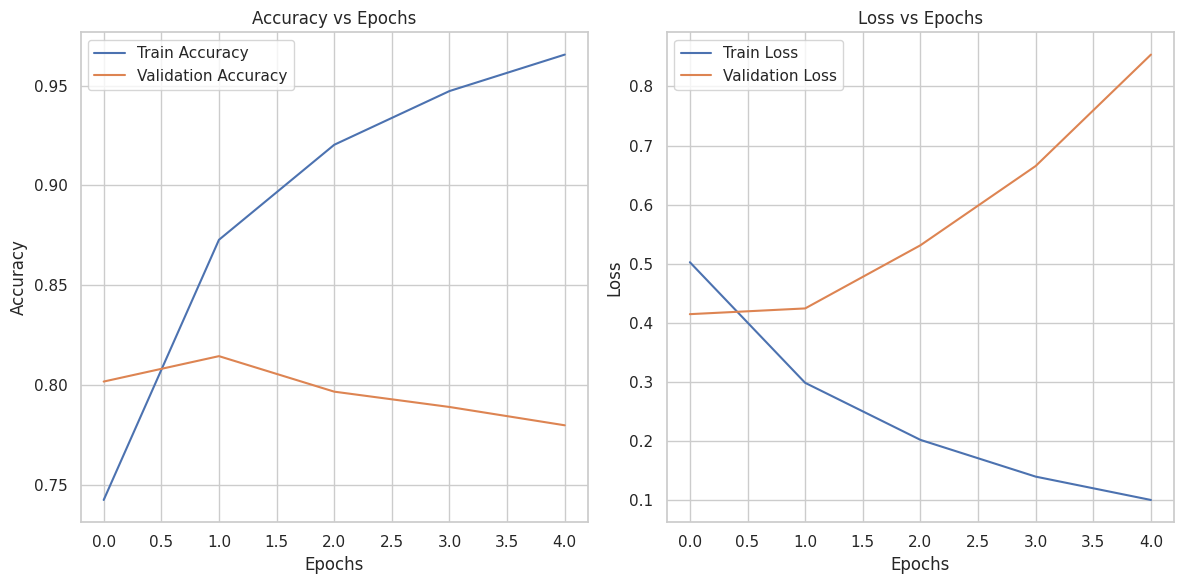

In [8]:
# Melatih model
history = model.fit(X_latih_seq, y_latih, epochs=5, batch_size=64, validation_data=(X_uji_seq, y_uji))

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(X_uji_seq, y_uji)
print(f"Accuracy on test data: {accuracy*100:.2f}%")

# Visualisasi akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Import
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
import numpy as np

# Grid search setup
hidden_units_list = [32, 64]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]

# Untuk simpan hasil
hasil_tuning = []

# Loop semua kombinasi
for hidden_units in hidden_units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"\n🚀 Training dengan hidden_units={hidden_units}, dropout={dropout_rate}, lr={learning_rate}, batch_size={batch_size}")

                # Build model
                model = models.Sequential([
                    layers.Embedding(input_dim=len(kamus_kata), output_dim=128, input_length=panjang_sequence),
                    layers.Bidirectional(layers.LSTM(hidden_units,
                                                     dropout=dropout_rate,
                                                     recurrent_dropout=dropout_rate,
                                                     kernel_regularizer=regularizers.l2(0.001))),
                    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                    layers.Dense(1, activation='sigmoid')
                ])

                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

                # Training
                history = model.fit(X_latih_seq, y_latih,
                                    validation_data=(X_uji_seq, y_uji),
                                    epochs=5,  # Tanpa EarlyStopping
                                    batch_size=batch_size,
                                    verbose=2)

                # Ambil val_accuracy terakhir
                val_acc = history.history['val_accuracy'][-1]
                print(f"🎯 Validation Accuracy: {val_acc:.4f}")

                # Simpan hasil
                hasil_tuning.append({
                    'hidden_units': hidden_units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'val_accuracy': val_acc
                })

# Urutkan berdasarkan val_accuracy
hasil_tuning = sorted(hasil_tuning, key=lambda x: x['val_accuracy'], reverse=True)

# Tampilkan 5 terbaik
print("\n🏆 5 Kombinasi Hyperparameter Terbaik:")
for i, hasil in enumerate(hasil_tuning[:5]):
    print(f"{i+1}. {hasil}")



🚀 Training dengan hidden_units=32, dropout=0.3, lr=0.001, batch_size=32
Epoch 1/5
668/668 - 160s - 239ms/step - accuracy: 0.7454 - loss: 0.5479 - val_accuracy: 0.7991 - val_loss: 0.4413
Epoch 2/5
668/668 - 156s - 233ms/step - accuracy: 0.8606 - loss: 0.3435 - val_accuracy: 0.8014 - val_loss: 0.4511
Epoch 3/5
668/668 - 190s - 285ms/step - accuracy: 0.9002 - loss: 0.2728 - val_accuracy: 0.8066 - val_loss: 0.4749
Epoch 4/5
668/668 - 214s - 320ms/step - accuracy: 0.9257 - loss: 0.2132 - val_accuracy: 0.7988 - val_loss: 0.5411
Epoch 5/5
668/668 - 158s - 237ms/step - accuracy: 0.9474 - loss: 0.1691 - val_accuracy: 0.7924 - val_loss: 0.6302
🎯 Validation Accuracy: 0.7924

🚀 Training dengan hidden_units=32, dropout=0.3, lr=0.001, batch_size=64
Epoch 1/5
334/334 - 100s - 300ms/step - accuracy: 0.7170 - loss: 0.5983 - val_accuracy: 0.7928 - val_loss: 0.4501
Epoch 2/5
334/334 - 143s - 428ms/step - accuracy: 0.8605 - loss: 0.3503 - val_accuracy: 0.8014 - val_loss: 0.4437
Epoch 3/5
334/334 - 142s -

167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step

📊 Matriks Evaluasi Model:
Accuracy  : 0.7980
Precision : 0.7707
Recall    : 0.7684
F1-Score  : 0.7696
AUC Score : 0.8830


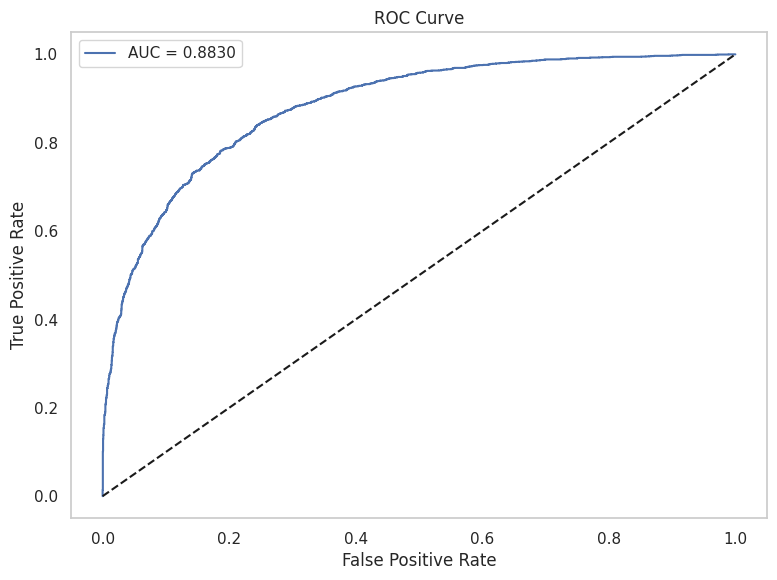

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi pada data uji
y_pred_prob = model.predict(X_uji_seq)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Hitung Metrics
akurasi = accuracy_score(y_uji, y_pred)
presisi = precision_score(y_uji, y_pred)
recall = recall_score(y_uji, y_pred)
f1 = f1_score(y_uji, y_pred)
auc = roc_auc_score(y_uji, y_pred_prob)

print("\n📊 Matriks Evaluasi Model:")
print(f"Accuracy  : {akurasi:.4f}")
print(f"Precision : {presisi:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"AUC Score : {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_uji, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


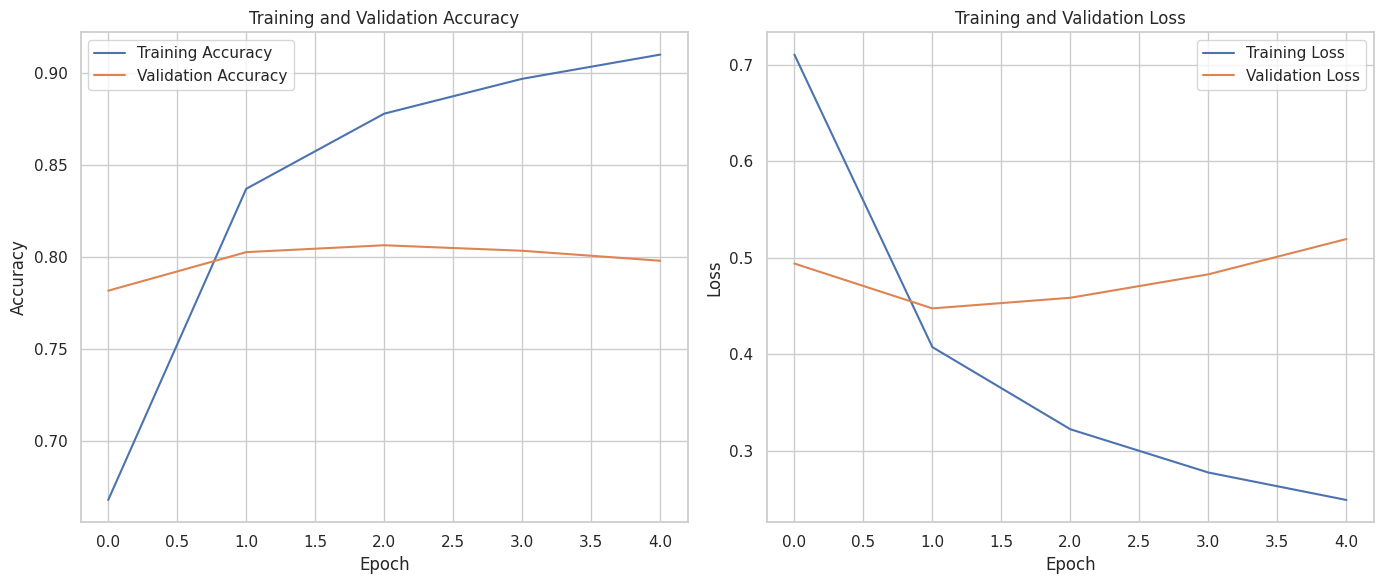

In [11]:
# Visualisasi Training Accuracy dan Loss
plt.figure(figsize=(14,6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


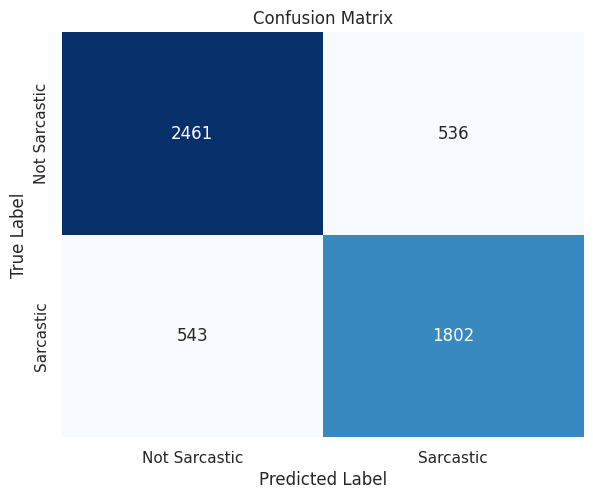

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Buat Confusion Matrix
cm = confusion_matrix(y_uji, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Deep RNN Model (Tensorflow)

In [13]:
# 1. Load dataset (kalau belum)
X_latih_seq = np.load('X_latih_seq.npy')
X_uji_seq = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')

# 2. Bangun model Deep RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

model_rnn = Sequential([
    Embedding(input_dim=len(kamus_kata), output_dim=128, input_length=100),
    SimpleRNN(128, return_sequences=True),   # Layer RNN 1
    Dropout(0.3),
    SimpleRNN(64, return_sequences=True),    # Layer RNN 2
    Dropout(0.3),
    SimpleRNN(32),                           # Layer RNN 3
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# 3. Compile model
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Train model
history_rnn = model_rnn.fit(
    X_latih_seq, y_latih,
    validation_data=(X_uji_seq, y_uji),
    epochs=10,
    batch_size=64
)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 62s 167ms/step - accuracy: 0.5350 - loss: 0.7001 - val_accuracy: 0.5610 - val_loss: 0.6864
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - accuracy: 0.5560 - loss: 0.6882 - val_accuracy: 0.5608 - val_loss: 0.6867
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 82s 166ms/step - accuracy: 0.5589 - loss: 0.6866 - val_accuracy: 0.5610 - val_loss: 0.6859
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.5587 - loss: 0.6872 - val_accuracy: 0.5608 - val_loss: 0.6861
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.5588 - loss: 0.6871 - val_accuracy: 0.5610 - val_loss: 0.6859
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 54s 162ms/step - accuracy: 0.5588 - loss: 0.6866 - val_accuracy: 0.5610 - val_loss: 0.6858
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 55s 163ms/step - accuracy: 0.5588 - loss: 0.6862 - val_accuracy: 0.5610 - val_loss: 0.6858
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.5589 - loss: 0

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi
y_pred_prob_rnn = model_rnn.predict(X_uji_seq)
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)

# Hitung metrik
acc = accuracy_score(y_uji, y_pred_rnn)
prec = precision_score(y_uji, y_pred_rnn)
rec = recall_score(y_uji, y_pred_rnn)
f1 = f1_score(y_uji, y_pred_rnn)
auc = roc_auc_score(y_uji, y_pred_prob_rnn)

print("\n📈 Evaluasi Deep RNN:")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step

📈 Evaluasi Deep RNN:
Akurasi  : 0.5610
Presisi  : 0.0000
Recall   : 0.0000
F1-Score : 0.0000
AUC      : 0.4995


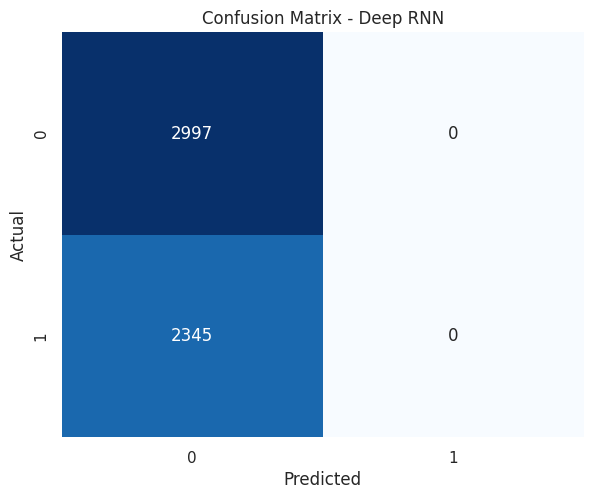

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_uji, y_pred_rnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Deep RNN')
plt.show()


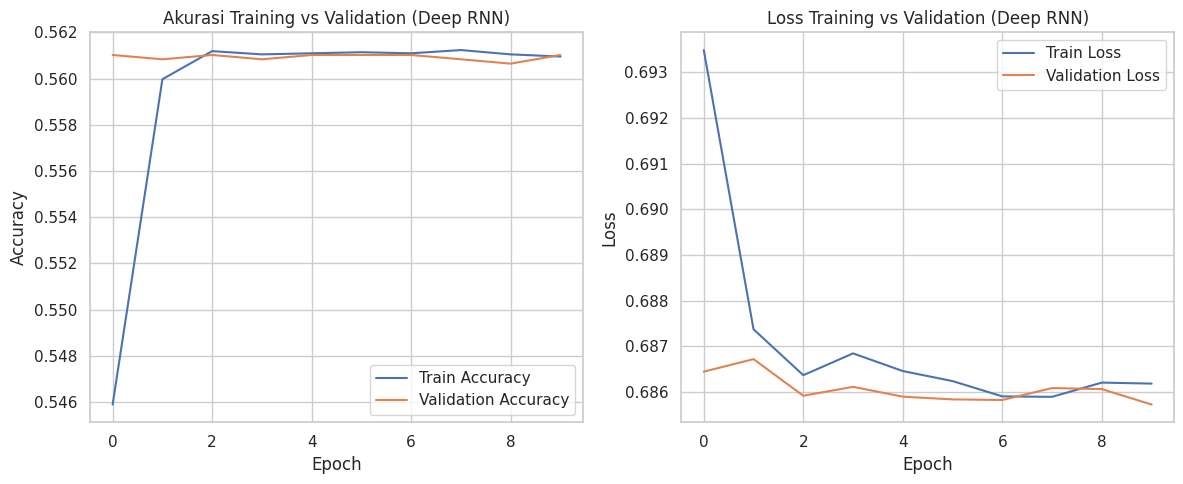

In [16]:
# Akurasi
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Training vs Validation (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Training vs Validation (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()